# Preprocessing calcium acquisition
* anatomy images
* motion correction



In [1]:
from src.sample import Sample
from src.utils import image_utils
import napari
import numpy as np
import importlib


In [13]:
importlib.reload(image_utils)

<module 'src.utils.image_utils' from 'C:\\Users\\montruth\\PycharmProjects\\samplePy\\src\\utils\\image_utils.py'>

In [2]:
# Load sample from path 
sample_path = '../data/calcium/2022-04-26/f3/20220426_RM0008_130hpf_fP1_f3_pickle'

sample= Sample.load_sample(sample_path)
print(sample)


Sample ID: 20220426_RM0008_130hpf_fP1_f3


In [4]:
sample.exp

namespace(paramsOdor=namespace(odorList=['o1Ala',
                                         'o2Ser',
                                         'o3TDCA',
                                         'o4Ctrl',
                                         'o5GCA',
                                         'o6TCA',
                                         'o7Cad',
                                         'o8SA'],
                               odorSequence=[1,
                                             2,
                                             3,
                                             4,
                                             6,
                                             7,
                                             5,
                                             8,
                                             5,
                                             7,
                                             6,
                                             4,
                      

In [3]:
trial1_path='../data/calcium/2022-04-26/f3/20220426_RM0008_130hpf_fP1_f3_t1_o1Ala_001_.tif'
trial2_path= '../data/calcium/2022-04-26/f3/20220426_RM0008_130hpf_fP1_f3_t2_o2Ser_001_.tif'
anatomy_stack_path = '../data/calcium/2022-04-26/f3/20220426_RM0008_130hpf_fP1_f3_anatomyGFRF_001_.tif'

nPlanes = sample.get_param('nPlanes')
nFrames = sample.get_param('nFrames')
nSlices = sample.get_param('anatoRange')

nFramesTrial = nFrames // nPlanes

In [4]:
planes_trial1 = image_utils.load_planes_from_tif(trial1_path, nPlanes)
planes_trial2 = image_utils.load_planes_from_tif(trial2_path, nPlanes)

(4, 375, 512, 512)
(8, 375, 256, 512)
(4, 375, 512, 512)
(8, 375, 256, 512)


In [5]:
# Create ignore_vector

# Parameters
ignore_until = 75
nTrials = 2
# Generate an array of zeros of length 750
ignore_vector = np.ones(nFramesTrial, dtype=bool)

# Set the first 16 elements to True (equivalent to 1 in a binary array)
ignore_vector[:ignore_until] = False
print(ignore_vector.shape)
ignore_vector = np.tile(ignore_vector,nTrials)
print(ignore_vector)

(375,)
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  

# Motion correction

In [33]:

# Stitch images
images = np.concatenate((planes_trial1, planes_trial2), axis=1)
print(images.shape)


# Mask images
# Compute the minimum value of the entire images array
min_value = np.min(images[:,ignore_vector,:,:])
print(min_value)
min_value = 0

# Create a full array of the minimum value with the same shape as slices
min_images = np.full_like(images[:, 0, :, :], min_value)

# Apply the ignore vector
# Use np.where to choose between the min_images and the original images based on the ignore_vector
masked_images = np.where(ignore_vector[:, np.newaxis, np.newaxis], images, min_images[:, np.newaxis, :, :])

viewer = napari.Viewer()
viewer.add_image(masked_images)
print("Resulting images shape:", masked_images.shape)

# Apply gaussian1d
from scipy.ndimage import gaussian_filter1d
sigma = 5
gaussian_images =  gaussian_filter1d(masked_images, sigma=sigma, axis=1)
print(gaussian_images)

MemoryError: Unable to allocate 5.86 GiB for an array with shape (8, 750, 256, 512) and data type float64

In [34]:
frames = images[0,ignore_vector,:,:]
print(frames.shape)
binned_images = np.reshape(frames, (frames.shape[0]//ignore_until, ignore_until,  frames.shape[1], frames.shape[2])).sum(axis=1)
viewer.add_image(binned_images)
print(binned_images.shape)


(600, 256, 512)
(8, 256, 512)


In [35]:

viewer.add_image(gaussian_images, name='filtered_gaussian_images')
viewer.add_image(binned_images, name='binned_images')

<Image layer 'binned_images [5]' at 0x1a8be119310>

In [36]:
reference_images = masked_images[:,:200,:,:].sum(axis=1)
print(reference_images.shape)
viewer.add_image(reference_images, name='reference_image')

(8, 256, 512)


<Image layer 'reference_image [2]' at 0x1a8be0dba90>

In [37]:
from skimage.registration import phase_cross_correlation
import math

print(masked_images[0].shape)
frames=np.squeeze(np.array(binned_images))
frames = binned_images
print(frames.shape)
reference_image = reference_images[0]
print(reference_image.shape)

# Initialize displacement arrays to the number of frames
num_frames = frames.shape[0]  # Ensure this matches your actual data shape
Xs = np.zeros(num_frames)
Ys = np.zeros(num_frames)
total_motion = np.zeros(num_frames)

# Compute phase correlation for each frame against the reference
for i in range(num_frames):
    X = phase_cross_correlation(reference_image, frames[i, :, :], upsample_factor=2, space='real')
    Xs[i] = X[0][0]  # x-displacement
    Ys[i] = X[0][1]  # y-displacement
    total_motion[i] = math.sqrt(Xs[i]**2 + Ys[i]**2)

(750, 256, 512)
(8, 256, 512)
(256, 512)


Text(0, 0.5, 'Y Shifts')

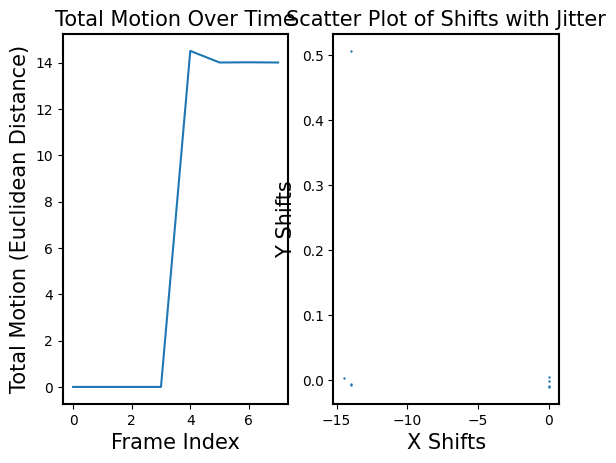

In [38]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.plot(total_motion)
plt.title("Total Motion Over Time")
plt.xlabel("Frame Index")
plt.ylabel("Total Motion (Euclidean Distance)")

plt.subplot(1,2,2)
plt.scatter(Xs-0.01+0.02*np.random.rand(Xs.shape[0]), Ys-0.01+0.02*np.random.rand(Ys.shape[0]), s=0.5)
plt.title("Scatter Plot of Shifts with Jitter")
plt.xlabel("X Shifts")
plt.ylabel("Y Shifts")

In [39]:
from scipy.ndimage import shift
aligned_frames=np.zeros(frames.shape)
for i in range(frames.shape[0]):
    aligned_frames[i,:,:]=shift(frames[i,:,:], (Xs[i],Ys[i]), output=None, order=3, mode='constant', cval=8100, prefilter=True)

In [40]:
aligned_anatomy=np.sum(aligned_frames,0)

viewer.add_image(aligned_frames, name='aligned_frames')


<Image layer 'aligned_frames' at 0x1a8be6167d0>